### Taskfor Week 2.
    1. Solve the system numerically using solver in Matlab or Python.
    2. Compare  obtained  results  with  previous  week. How  and  why  do  they  differ? Plot all the  graphs  for Russia and the USA.
    3.  There  are  many modifications of  the model  accounting  different  features  and  scenarios of  diseases. Describe which and why do perform better in case of COVID, Ebola, measles, flu?

# Task 1: Solve the system numerically using solver in Matlab or Python.

# Minimization problem formalization

Let $I_{real}(t_i)$ - an amount of infected people at the time moment $t_i$ and $I_{model}(\beta,\gamma,\delta,t_i)$ - predicted amount of infected people at the same moment.

We are to find the set of optimal parameters $\beta,\gamma,\delta$ to minimize the difference between real and predicted amounts. Therefore this task can be formalized as follows:

$
\begin{equation*}
\beta,\gamma,\delta = argmin\left[\sum_{t=0}^{T} (I_{real}(t_i) - I_{model}(\beta,\gamma,\delta,t_i))^2\right], \text{with the following set of constrains (to avoid infinite and negative values): }\\
\begin{cases}
0 \leq \beta \leq \beta_{up}  \\
0 \leq \gamma \leq \gamma_{up}\\
0 \leq \delta \leq \delta_{up} \\
\end{cases}
\text{, where} \\
\beta_{up},\gamma_{up},\delta_{up} \text{ - upper bounds for these values;} \\
\beta - \text{the effective contact rate of the disease: proportional coeffitient between probability of susceptible and infectious individuals contact;} \\
\gamma - \text{the removing rate: the number of removedpeople per time is proportional to the number of infectious individuals;} \\
\delta - \text{vertical bias to setup graph properly;} \\
T - \text{the number of iterations (partiqular time moments).} \\
\end{equation*}
$
Initial conditions $\beta_{0},\gamma_{0},\delta_{0}$ can be set more-less randomly (in reasonable bounds shown in constrains), but sometimes for this model, they are required to be manually chosen in case of non-stable solution.

We chose upper bounds in the following limits: $0 \leq \beta_{0} \leq 1,0 \leq \gamma_{0} \leq 1,0 \leq \delta_{0} \leq 0.25$

As the final metric to compare manually - chosen coefficients we can use the following expression:

$e = \frac{\sqrt{\sum_{t=0}^{T} (I_{real}(t_i) - I_{model}(t_i))^2}} {\sqrt{\sum_{t=0}^{T} (I_{real}(t_i))^2} \sqrt{\sum_{t=0}^{T} (I_{model}(t_i))^2}}$, where 

$I_{real}$ - real data;

$I_{model}$ - estimated curve;

$i$ - time moment, $i \in [0...T]$.



This metric is just the norm of the difference between real and estimated vectors normalized by norms of these vectors.

For the optimization task Nodler-mead method of scipy.optimize module has been used. Let's describe this method in more detail:

#### The Nelder–Mead method
is numerical direct search used to find the extremum of an objective function in a multidimensional space. It is often applied to nonlinear optimization problems for which derivatives may not be known.

The algorithm consists of the formation of a simplex and its subsequent deformation in the direction of the minimum, by means of three operations:
* 1) Reflection;
* 2) Expansion;
* 3) Compression (contract);

So, the whole method can be described using the following steps: Simplex initialization; Search for the centre of gravity; Make reflection; Do either contraction or expansion (it depends on conditions); Make shrinkage.

A simplex is an n-dimensional generalization of a triangle. For one-dimensional space it is a segment, for two-dimensional space, it is a triangle.
Main steps:
* 1) Let $ f (x, y) $ be the function to be optimized. At the first step, we select three random points (more on this later) and form a simplex (triangle). We calculate the value of the function at each point and sort it: $f(V_2) (best,b) \leq f(V_1) (good,g) \leq f(V_3) (worst,w).$

* 2) At the next step, we find the midpoint of the b-g segment as half-sum of the b,g coordinates: $ mid = \left (\frac {x_1 + x_2} 2; \frac {y_1 + y_2} 2 \right) $


* 3) Then we apply the reflection operation (reflecting point $w$ relative to $mid$):
Find the point $ x_r $, as follows: $ x_r = mid + \alpha (mid - w) $ , $\alpha = 1$.

If $ f (x_r) < f(g) $, then $ x_r $ is a good point.

* 4) Apply the stretching operation: find the point $ x_e $ as follows: $ x_e = mid + \gamma (x_r - mid), \gamma = 2$, i.e. the distance is doubled. If $ f (x_e) < f (b) $, then we found a point better than current point (in opposite case, we would have stopped at the $ x_r $ point). Next, we replace the point $w$ with $ x_e $.

* 5) If we did not find good points, we try the compression operation. We shrink our segment and look for good points inside the triangle: $ x_c $: $ x_c = mid + \beta (w - mid), \beta = 0.5.$, i.e. point $ x_c $ in the middle of the $w-mid$ segment.

This method is heuristic. There is no ideal way to select initialization points, they can be chosen randomly (images and description are from https://habr.com/ru/post/332092/).

![image](method.png)

In [1]:
def estimate_metric(x_real,x_estimated):
    e = np.sqrt(np.mean((x_real-x_estimated)**2))
    return e

In [2]:
from scipy.optimize import minimize, rosen, rosen_der
import pandas as pd
%pylab inline
import warnings
warnings.filterwarnings("ignore")

def optimize_I(x):
    # initial conditions
    N = 1000
    S0 = N - 1
    I0 = N - S0
    R0 = 0
    SIR = [[],[],[],[]]
    S,I,R = S0,I0,R0
    SIR[0].append(S0),SIR[1].append(I0),SIR[2].append(R0)
    real_data = DATA
    for t in range(duration):
        S,I,R = S - x[0]*S*I/N, I + x[0]*S*I/N - x[1]*I, R + x[1]*I
        SIR[0].append(S)
        SIR[1].append(I)
        SIR[2].append(R)
    calculated_data = np.array(SIR[1])/N
    bias_penalty = np.ones(len(real_data))*x[2]
    to_minimize = np.sum((real_data - calculated_data - bias_penalty)**2)
    return to_minimize

def optimize_R(x):
    # initial conditions
    N = 1000
    S0 = N - 1
    I0 = N - S0
    R0 = 0
    SIR = [[],[],[],[]]
    S,I,R = S0,I0,R0
    SIR[0].append(S0),SIR[1].append(I0),SIR[2].append(R0)
    real_data = DATA
    for t in range(duration):
        S,I,R = S - x[0]*S*I/N, I + x[0]*S*I/N - x[1]*I, R + x[1]*I
        SIR[0].append(S)
        SIR[1].append(I)
        SIR[2].append(R)
    calculated_data = np.array(SIR[2])/N
    bias_penalty = np.ones(len(real_data))*x[2]
    to_minimize = np.sum((real_data - calculated_data - bias_penalty)**2)
    return to_minimize

lw = 4 # linewidth
fs = 20 # fontsize

def get_graph(beta,gamma,duration):
    N = 1000 # total amount of people (S+I+R = const)

    S0 = N - 1 # suspected (at least 1 infected)
    I0 = N - S0 # infected
    R0 = 0 # immune + dead

    SIR = [[],[],[],[]] # to collect statistics
    # add initial conditions
    SIR[0].append(S0/N)
    SIR[1].append(I0/N)
    SIR[2].append(R0/N)
    # initialize conditions
    S,I,R = S0,I0,R0
    # solve equation several times
    for t in range(duration):
        # calculate all equations simultaniously
        S,I,R = S - beta*S*I/N, I + beta*S*I/N - gamma*I, R + gamma*I

        # collect t-th iteration statistics
        SIR[0].append(S/N)
        SIR[1].append(I/N)
        SIR[2].append(R/N)
        SIR[3].append(S+I+R) # to be sure if total population is contant
    return SIR

# minimization methods to be used
method = [None,'Nelder-Mead','Powell','CG','BFGS','Newton-CG','L-BFGS-B','SLSQP']
# method = ['Nelder-Mead','Powell','CG','BFGS','Newton-CG','L-BFGS-B','SLSQP']

Populating the interactive namespace from numpy and matplotlib


## Infected people from Russia an USA fitting

Text(410, 0.8, '$\\gamma=$0.008')

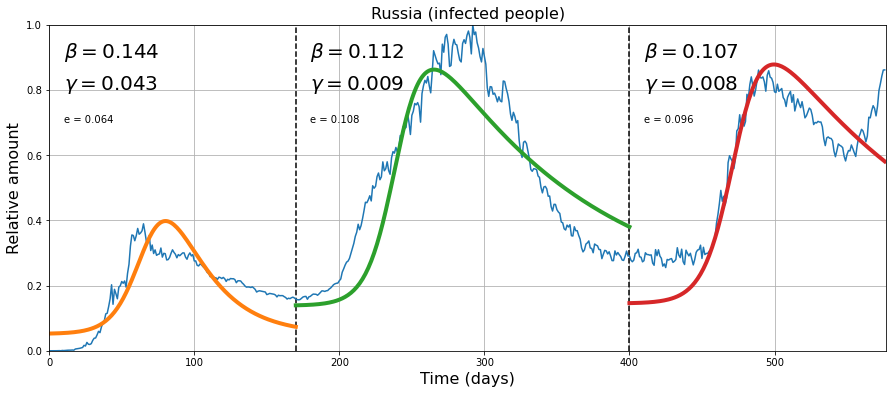

In [3]:
df_Rus_Inf = pd.read_csv('russia_All_waves_I.csv')

figure(figsize=(15,6))
title('Russia (infected people)', fontsize=16)
# plot initial statistics
plot(df_Rus_Inf['7']/max(df_Rus_Inf['7']))

### WAVE 1
# wave duration
duration = 170
# wave start sample
start = 0
# wave end sample
stop = start + duration + 1
# current wave data
DATA = np.array((df_Rus_Inf['7']/max(df_Rus_Inf['7']))[start:stop])
# initial values of [beta,gamma,bias(vertical)]
x0 = [0.15,0.05,0.0]
# values bounds
bnds = ((0,0.3),(0,0.1),(0,0.25))
# minimized parameters
res = minimize(optimize_I, x0, method=method[0], tol=1e-1,bounds=bnds).x
beta1,gamma1,bias1 = res[0],res[1],res[2]
# SIR with the current set of parameters
SIR = get_graph(beta=beta1,gamma=gamma1,duration=duration)
m1 = text(10,0.7,'e = '+ str(round(estimate_metric(DATA,np.array(SIR[1]) + bias1),3)))
plot(np.arange(duration+1),np.array(SIR[1]) + bias1, label = 'I',linewidth=lw)
vlines(170,0,1,'k','--')

# WAVE 2
duration = 230
start = 170
stop = start + duration + 1
DATA = np.array((df_Rus_Inf['7']/max(df_Rus_Inf['7']))[start:stop])
x0 = [0.15,0.01,0.1]
bnds = ((0,0.3),(0,0.1),(0,0.25))
res = minimize(optimize_I, x0, method=method[0], tol=1e-1,bounds=bnds).x
beta2,gamma2,bias2 = res[0],res[1],res[2]
SIR = get_graph(beta=beta2,gamma=gamma2,duration=duration)
m2 = text(180,0.7,'e = '+ str(round(estimate_metric(DATA,np.array(SIR[1]) + bias2),3)))
plot(np.arange(duration+1)+start,np.array(SIR[1]) + bias2, label = 'I',linewidth=lw)
vlines(400,0,1,'k','--')

# WAVE 3
duration = 176
start = 400
stop = start + duration + 1
DATA = np.array((df_Rus_Inf['7']/max(df_Rus_Inf['7']))[start:stop])
x0 = [0.15,0.01,0.1]
bnds = ((0,0.3),(0,0.1),(0,0.25))
res = minimize(optimize_I, x0, method=method[0], tol=1e-1,bounds=bnds).x
beta3,gamma3,bias3 = res[0],res[1],res[2]
SIR = get_graph(beta=beta3,gamma=gamma3,duration=duration)
m3 = text(410,0.7,'e = '+ str(round(estimate_metric(DATA,np.array(SIR[1]) + bias3),3)))
plot(np.arange(duration+1)+start,np.array(SIR[1]) + bias3, label = 'I',linewidth=lw)

xlabel('Time (days)',fontsize=16)
ylabel('Relative amount',fontsize=16)
xlim(0,len(df_Rus_Inf))
ylim(0,1)
grid()

# to plot betas and gammas
text(10,0.9, '$\\beta=$' + str(round(beta1,3)),fontsize=fs)
text(10,0.8, '$\\gamma=$' + str(round(gamma1,3)),fontsize=fs)
text(180,0.9, '$\\beta=$' + str(round(beta2,3)),fontsize=fs)
text(180,0.8, '$\\gamma=$' + str(round(gamma2,3)),fontsize=fs)
text(410,0.9, '$\\beta=$' + str(round(beta3,3)),fontsize=fs)
text(410,0.8, '$\\gamma=$' + str(round(gamma3,3)),fontsize=fs)

Text(510, 0.8, '$\\gamma=$0.077')

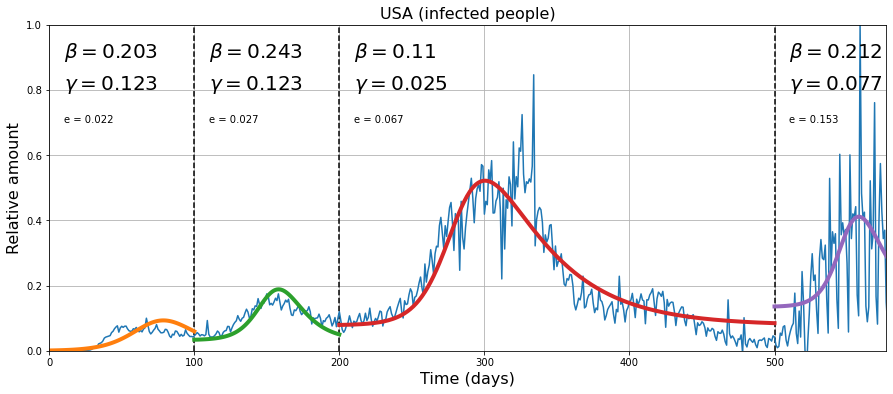

In [4]:
df_USA_Inf = pd.read_csv('USA_Infected.csv')

figure(figsize=(15,6))
title('USA (infected people)', fontsize=16)
# plot initial statistics
plot(df_USA_Inf['15']/max(df_USA_Inf['15']))

### WAVE 1
# wave duration
duration = 100
# wave start sample
start = 0
# wave end sample
stop = start + duration + 1
# current wave data
DATA = np.array((df_USA_Inf['15']/max(df_USA_Inf['15']))[start:stop])
# initial values of [beta,gamma,bias(vertical)]
x0 = [0.21,0.12,0.0]
# values bounds
bnds = ((0,0.3),(0,0.2),(0,0.25))
# minimized parameters
res = minimize(optimize_I, x0, method=method[0], tol=1e-1,bounds=bnds).x
beta1,gamma1,bias1 = res[0],res[1],res[2]
# SIR with the current set of parameters
SIR = get_graph(beta=beta1,gamma=gamma1,duration=duration)
m1 = text(10,0.7,'e = '+ str(round(estimate_metric(DATA,np.array(SIR[1]) + bias1),3)))
plot(np.arange(duration+1),np.array(SIR[1]) + bias1, label = 'I',linewidth=lw)
vlines(100,0,1,'k','--')

# WAVE 2
duration = 100
start = 100
stop = start + duration + 1
DATA = np.array((df_USA_Inf['15']/max(df_USA_Inf['15']))[start:stop])
x0 = [0.24,0.13,0.02]
bnds = ((0,0.3),(0,0.2),(0,0.25))
res = minimize(optimize_I, x0, method=method[0], tol=1e-1,bounds=bnds).x
beta2,gamma2,bias2 = res[0],res[1],res[2]
SIR = get_graph(beta=beta2,gamma=gamma2,duration=duration)
m2 = text(110,0.7,'e = '+ str(round(estimate_metric(DATA,np.array(SIR[1]) + bias2),3)))
plot(np.arange(duration+1)+start,np.array(SIR[1]) + bias2, label = 'I',linewidth=lw)
vlines(200,0,1,'k','--')

# WAVE 3
duration = 300
start = 200
stop = start + duration + 1
DATA = np.array((df_USA_Inf['15']/max(df_USA_Inf['15']))[start:stop])
x0 = [0.25,0.02,0.1]
bnds = ((0,0.5),(0,0.1),(0,0.25))
res = minimize(optimize_I, x0, method=method[0], tol=1e-1,bounds=bnds).x
beta3,gamma3,bias3 = res[0],res[1],res[2]
SIR = get_graph(beta=beta3,gamma=gamma3,duration=duration)
m3 = text(210,0.7,'e = '+ str(round(estimate_metric(DATA,np.array(SIR[1]) + bias3),3)))
plot(np.arange(duration+1)+start,np.array(SIR[1]) + bias3, label = 'I',linewidth=lw)
vlines(500,0,1,'k','--')

# WAVE 4
duration = 92
start = 500
stop = start + duration + 1
DATA = np.array((df_USA_Inf['15']/max(df_USA_Inf['15']))[start:stop])
x0 = [0.125,0.15,0.1]
bnds = ((0,0.5),(0,0.1),(0,0.25))
res = minimize(optimize_I, x0, method=method[0], tol=1e-1,bounds=bnds).x
beta4,gamma4,bias4 = res[0],res[1],res[2]
SIR = get_graph(beta=beta4,gamma=gamma4,duration=duration)
m4 = text(510,0.7,'e = '+ str(round(estimate_metric(DATA,np.array(SIR[1]) + bias4),3)))
plot(np.arange(duration+1)+start,np.array(SIR[1]) + bias4, label = 'I',linewidth=lw)

xlabel('Time (days)',fontsize=16)
ylabel('Relative amount',fontsize=16)
xlim(0,len(df_Rus_Inf))
ylim(0,1)
grid()

# to plot betas and gammas
text(10,0.9, '$\\beta=$' + str(round(beta1,3)),fontsize=fs)
text(10,0.8, '$\\gamma=$' + str(round(gamma1,3)),fontsize=fs)
text(110,0.9, '$\\beta=$' + str(round(beta2,3)),fontsize=fs)
text(110,0.8, '$\\gamma=$' + str(round(gamma2,3)),fontsize=fs)
text(210,0.9, '$\\beta=$' + str(round(beta3,3)),fontsize=fs)
text(210,0.8, '$\\gamma=$' + str(round(gamma3,3)),fontsize=fs)
text(510,0.9, '$\\beta=$' + str(round(beta4,3)),fontsize=fs)
text(510,0.8, '$\\gamma=$' + str(round(gamma4,3)),fontsize=fs)

## Removed (dead and imuune individuals) people from Russia an USA fitting

Text(410, 0.8, '$\\gamma=$0.011')

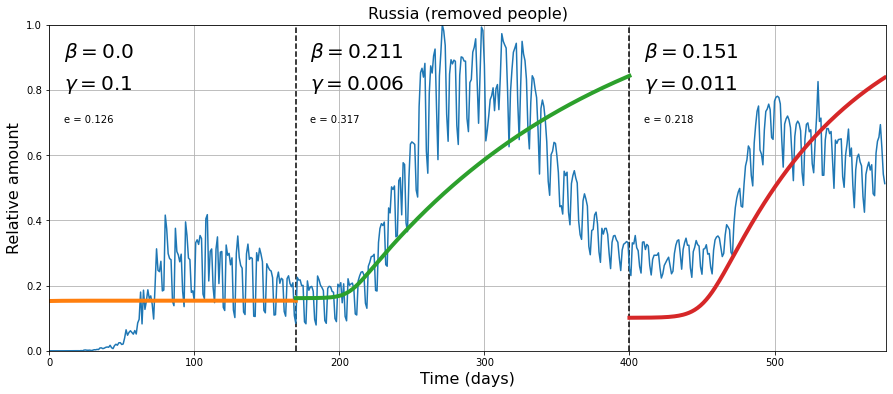

In [5]:
df_RUS_R = pd.read_csv('Russia_R.csv')

figure(figsize=(15,6))
title('Russia (removed people)', fontsize=16)
# plot initial statistics
plot(df_RUS_R['1']/max(df_RUS_R['1']))

### WAVE 1
# wave duration
duration = 170
# wave start sample
start = 0
# wave end sample
stop = start + duration + 1
# current wave data
DATA = np.array((df_RUS_R['1']/max(df_RUS_R['1']))[start:stop])
# initial values of [beta,gamma,bias(vertical)]
x0 = [0.2,0.05,0.0]
# values bounds
bnds = ((0,0.3),(0,0.1),(0,0.25))
# minimized parameters
res = minimize(optimize_R, x0, method=method[0], tol=1e-1,bounds=bnds).x
beta1,gamma1,bias1 = res[0],res[1],res[2]
# SIR with the current set of parameters
SIR = get_graph(beta=beta1,gamma=gamma1,duration=duration)
m1 = text(10,0.7,'e = '+ str(round(estimate_metric(DATA,np.array(SIR[1]) + bias1),3)))
plot(np.arange(duration+1),np.array(SIR[2]) + bias1, label = 'I',linewidth=lw)
vlines(170,0,1,'k','--')

# WAVE 2
duration = 230
start = 170
stop = start + duration + 1
DATA = np.array((df_RUS_R['1']/max(df_RUS_R['1']))[start:stop])
x0 = [0.15,0.01,0.1]
bnds = ((0,0.3),(0,0.1),(0,0.25))
res = minimize(optimize_R, x0, method=method[0], tol=1e-1,bounds=bnds).x
beta2,gamma2,bias2 = res[0],res[1],res[2]
SIR = get_graph(beta=beta2,gamma=gamma2,duration=duration)
m2 = text(180,0.7,'e = '+ str(round(estimate_metric(DATA,np.array(SIR[1]) + bias2),3)))
plot(np.arange(duration+1)+start,np.array(SIR[2]) + bias2, label = 'I',linewidth=lw)
vlines(400,0,1,'k','--')

# WAVE 3
duration = 176
start = 400
stop = start + duration + 1
DATA = np.array((df_RUS_R['1']/max(df_RUS_R['1']))[start:stop])
x0 = [0.15,0.01,0.1]
bnds = ((0,0.3),(0,0.1),(0,0.25))
res = minimize(optimize_R, x0, method=method[0], tol=1e-1,bounds=bnds).x
beta3,gamma3,bias3 = res[0],res[1],res[2]
SIR = get_graph(beta=beta3,gamma=gamma3,duration=duration)
m3 = text(410,0.7,'e = '+ str(round(estimate_metric(DATA,np.array(SIR[1]) + bias3),3)))
plot(np.arange(duration+1)+start,np.array(SIR[2]) + bias3, label = 'I',linewidth=lw)

xlabel('Time (days)',fontsize=16)
ylabel('Relative amount',fontsize=16)
xlim(0,len(df_RUS_R))
ylim(0,1)
grid()

# to plot betas and gammas
text(10,0.9, '$\\beta=$' + str(round(beta1,3)),fontsize=fs)
text(10,0.8, '$\\gamma=$' + str(round(gamma1,3)),fontsize=fs)
text(180,0.9, '$\\beta=$' + str(round(beta2,3)),fontsize=fs)
text(180,0.8, '$\\gamma=$' + str(round(gamma2,3)),fontsize=fs)
text(410,0.9, '$\\beta=$' + str(round(beta3,3)),fontsize=fs)
text(410,0.8, '$\\gamma=$' + str(round(gamma3,3)),fontsize=fs)

Text(510, 0.8, '$\\gamma=$0.158')

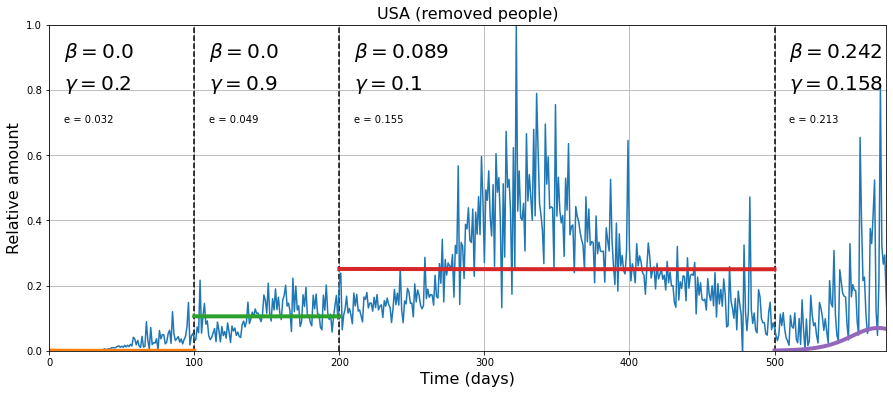

In [6]:
df_USA_R = pd.read_csv('USA_R_Corrected.csv')

figure(figsize=(15,6))
title('USA (removed people)', fontsize=16)
# plot initial statistics
plot(df_USA_R['3']/max(df_USA_R['3']))

### WAVE 1
# wave duration
duration = 100
# wave start sample
start = 0
# wave end sample
stop = start + duration + 1
# current wave data
DATA = np.array((df_USA_R['3']/max(df_USA_R['3']))[start:stop])
# initial values of [beta,gamma,bias(vertical)]
x0 = [0.15,0.1,0.0]
# values bounds
bnds = ((0,0.3),(0,0.2),(0,0.25))
# minimized parameters
res = minimize(optimize_R, x0, method=method[0], tol=1e-1,bounds=bnds).x
beta1,gamma1,bias1 = res[0],res[1],res[2]
# SIR with the current set of parameters
SIR = get_graph(beta=beta1,gamma=gamma1,duration=duration)
m1 = text(10,0.7,'e = '+ str(round(estimate_metric(DATA,np.array(SIR[1]) + bias1),3)))
plot(np.arange(duration+1),np.array(SIR[1]) + bias1, label = 'I',linewidth=lw)
vlines(100,0,1,'k','--')

# WAVE 2
duration = 100
start = 100
stop = start + duration + 1
DATA = np.array((df_USA_R['3']/max(df_USA_R['3']))[start:stop])
x0 = [0.5,0.4,0.0]
bnds = ((0,0.9),(0,0.9),(0,0.25))
res = minimize(optimize_R, x0, method=method[0], tol=1e-1,bounds=bnds).x
beta2,gamma2,bias2 = res[0],res[1],res[2]
SIR = get_graph(beta=beta2,gamma=gamma2,duration=duration)
m2 = text(110,0.7,'e = '+ str(round(estimate_metric(DATA,np.array(SIR[1]) + bias2),3)))
plot(np.arange(duration+1)+start,np.array(SIR[1]) + bias2, label = 'I',linewidth=lw)
vlines(200,0,1,'k','--')

# WAVE 3
duration = 300
start = 200
stop = start + duration + 1
DATA = np.array((df_USA_R['3']/max(df_USA_R['3']))[start:stop])
x0 = [0.25,0.4,0.0]
bnds = ((0,0.5),(0,0.1),(0,0.25))
res = minimize(optimize_R, x0, method=method[0], tol=1e-1,bounds=bnds).x
beta3,gamma3,bias3 = res[0],res[1],res[2]
SIR = get_graph(beta=beta3,gamma=gamma3,duration=duration)
m3 = text(210,0.7,'e = '+ str(round(estimate_metric(DATA,np.array(SIR[1]) + bias3),3)))
plot(np.arange(duration+1)+start,np.array(SIR[1]) + bias3, label = 'I',linewidth=lw)
vlines(500,0,1,'k','--')

# WAVE 4
duration = 92
start = 500
stop = start + duration + 1
DATA = np.array((df_USA_R['3']/max(df_USA_R['3']))[start:stop])
x0 = [0.25,0.15,0.0]
bnds = ((0,0.5),(0,0.1),(0,0.25))
res = minimize(optimize_R, x0, method=method[1], tol=1e-1,bounds=bnds).x
beta4,gamma4,bias4 = res[0],res[1],res[2]
SIR = get_graph(beta=beta4,gamma=gamma4,duration=duration)
m4 = text(510,0.7,'e = '+ str(round(estimate_metric(DATA,np.array(SIR[1]) + bias4),3)))
plot(np.arange(duration+1)+start,np.array(SIR[1]) + bias4, label = 'I',linewidth=lw)

xlabel('Time (days)',fontsize=16)
ylabel('Relative amount',fontsize=16)
xlim(0,len(df_Rus_Inf))
ylim(0,1)
grid()

# to plot betas and gammas
text(10,0.9, '$\\beta=$' + str(round(beta1,3)),fontsize=fs)
text(10,0.8, '$\\gamma=$' + str(round(gamma1,3)),fontsize=fs)
text(110,0.9, '$\\beta=$' + str(round(beta2,3)),fontsize=fs)
text(110,0.8, '$\\gamma=$' + str(round(gamma2,3)),fontsize=fs)
text(210,0.9, '$\\beta=$' + str(round(beta3,3)),fontsize=fs)
text(210,0.8, '$\\gamma=$' + str(round(gamma3,3)),fontsize=fs)
text(510,0.9, '$\\beta=$' + str(round(beta4,3)),fontsize=fs)
text(510,0.8, '$\\gamma=$' + str(round(gamma4,3)),fontsize=fs)

Using [1] metric we have estimated perfomance for both manually coefficients selection and optimization approach. From this point of view optimization approach prforms much better. You can easily verify this:

# Task 2: Compare  obtained  results  with  previous  week. How  and  why  do  they  differ? Plot all the  graphs  for Russia and the USA.

The results can be obtained in the following table. It can be seen that in all cases optimization approach performs much better in terms of [1] metric (normalized MSE). It is connected with the fact that we cannot choose coefficients properly manually because this is emperic approach. But optimization approach can bring us some reasonable result.

In [7]:
print('Results of manulal and optimization methods:')
print()
print('<---Infected people--->')
print()
print(' -> RUSSIA (manually)')
print('Wawe 1:',0.352)
print('Wawe 2:',0.111)
print('Wawe 3:',0.125)
print(' -> RUSSIA (optimization)')
print('Wawe 1:',0.107)
print('Wawe 2:',0.022)
print('Wawe 3:',0.02)
print()
print(' -> USA (manually)')
print('Wawe 1:',2.067)
print('Wawe 2:',0.909)
print('Wawe 3:',0.217)
print('Wawe 4:',0.342)
print(' -> USA (optimization)')
print('Wawe 1:',1.409)
print('Wawe 2:',0.406)
print('Wawe 3:',0.056)
print('Wawe 4:',0.212)
print()
print('<---Removed people--->')
print()
print(' -> RUSSIA (manually)')
print('Wawe 1:',0.384)
print('Wawe 2:',0.113)
print('Wawe 3:',0.145)
print(' -> RUSSIA (optimization)')
print('Wawe 1:',0.318)
print('Wawe 2:',0.051)
print('Wawe 3:',0.058)
print()
print(' -> USA (manually)')
print('Wawe 1:',3.052)
print('Wawe 2:',0.783)
print('Wawe 3:',0.186)
print('Wawe 4:',0.421)
print(' -> USA (optimization)')
print('Wawe 1:',600.08)
print('Wawe 2:',0.393)
print('Wawe 3:',0.116)
print('Wawe 4:',2.166)

Results of manulal and optimization methods:

<---Infected people--->

 -> RUSSIA (manually)
Wawe 1: 0.352
Wawe 2: 0.111
Wawe 3: 0.125
 -> RUSSIA (optimization)
Wawe 1: 0.107
Wawe 2: 0.022
Wawe 3: 0.02

 -> USA (manually)
Wawe 1: 2.067
Wawe 2: 0.909
Wawe 3: 0.217
Wawe 4: 0.342
 -> USA (optimization)
Wawe 1: 1.409
Wawe 2: 0.406
Wawe 3: 0.056
Wawe 4: 0.212

<---Removed people--->

 -> RUSSIA (manually)
Wawe 1: 0.384
Wawe 2: 0.113
Wawe 3: 0.145
 -> RUSSIA (optimization)
Wawe 1: 0.318
Wawe 2: 0.051
Wawe 3: 0.058

 -> USA (manually)
Wawe 1: 3.052
Wawe 2: 0.783
Wawe 3: 0.186
Wawe 4: 0.421
 -> USA (optimization)
Wawe 1: 600.08
Wawe 2: 0.393
Wawe 3: 0.116
Wawe 4: 2.166


# Task 3: There  are  many modifications of  the model  accounting  different  features  and  scenarios of  diseases. Describe which and why do perform better in case of COVID, Ebola, measles, flu?

Classical SIR model is look like this:
 $$
\begin{equation*}
\begin{cases}
\frac{dS}{dt} = - \beta \frac{SI}{N} \\
\frac{dI}{dt} = \beta \frac{SI}{N} - \gamma I \\
\frac{dR}{dt} = \gamma I \\
\end{cases}
\end{equation*}
\text{, where}
$$

$S$ - the number of people who could become infected;

$I$ - infectious - the number of infected people;

$R$ - deleted - number of unresponsive and dead people.


$\beta$ is the effective contact rate of the disease: proportional coeffitient between probability of susceptible and infectious individuals contact.

$\gamma$ is the removing rate: the number of removedpeople per time  is  proportional  to  the  number  of  infectious  individuals.

Current basic SIR model will be varying depending on the several factor such as: vaccination (for some of listed diseases there were exact vaccine, while for some it was absence during the peak of the pandemic), latent period (this factor will be peculiar to all diseases, but in different extent, because the latent period for all of them is differ), pandemic,endemic or epidemic nature of the particular disease (COVID-19 is very distributed all over the world in 2020-2021, while Ebola or Measles were pretty restricted during the outbreak and didn't distribute beyond Africa). So, currently there are several SIR models that will be varied depending on this factors. It must be said that even within one particular disease the model can be difficult depending on the state in which the outbreak happened.

So, there are the following SIR models(all these models were provided in recommended article:https://perso.uclouvain.be/georges.bastin/lectures-bio.pdf):

$1)$ Temporary immunity : the SIRS model for endemic diseases.\
$2)$ The SIR model with demography\
$3)$ SIR model with vaccination( this SIR model is for vaccine for newborn)\
$4)$ SEIR model with a latent period\
$5)$ Age structured SIR model\
$6)$ SIR model with time-varying parameters and periodic forcing\

In ideal situation every of these diseases will obey simultaniously to each model, but in different extent (so it's possible to neglect of some of these models for some outbreaks). Moreover theoretically its obligatory to make up SIR model for every separately taken state because the demography rate will be extremely differ in the North Korea (pretty close state with stable amount of population),the state of the West Europe (where emigration rate is large) and for instance the Russian Federation (significant population decline and immigration rate). So, ideally it's possible to make up the single universal SIR model that will include all these cases, but it will be very bulky and it will be sensible to neglect some parameters). Every disease will be considered induvidually in some spacial case.

# Ebola and Measles in Africa during current outbreaks:
Despite the fact, that The Ebola epidemic began in West Africa and even managed to expand outside the country and spreading to Liberia, Sierra Leone, Nigeria, Senegal, the United States, Spain and Mali still that disease remains pretty endemic and aren't peculiar to the well-developed states. That's why only for Ebola futher it will be used the  SIRS model for endemic diseases.

Currently there is vaccine against measles and all outbreaks just happened in local regions (frequently in Africa). So the vaccination has not been conducted in Africa, that's why for these both cases there will be used the SIRS model for endemic diseases:

$$
\begin{equation*}
\begin{cases}
\frac{dS}{dt} = - \beta \frac{SI}{N}  + \delta\ R\\
\frac{dI}{dt} = \beta \frac{SI}{N} - \gamma I \\
\frac{dR}{dt} = \gamma I \ - \delta\ R\\
\end{cases}
\end{equation*}
\text{, where}
$$

An additional parameter δ is introduced in order to represent the specific rate of immunity loss. 

# Measles in first world countries:

An effective vaccine is available that is widely administered to newborns, so for measles in fisrst world countries the SIR model with vaccination will be peculiar:

$$
\begin{equation*}
\begin{cases}
\frac{dS}{dt} = (\mu-\sigma)N - \beta \frac{SI}{N}   - \mu S \\
\frac{dI}{dt} = \beta \frac{SI}{N} - \gamma I - \mu I \\
\frac{dR}{dt} = \gamma I \ - \mu R \\
\end{cases}
\end{equation*}
\text{, where}
$$

A new parameter σ is introduced in the model which represents the specific vaccination rate of the newborns, while µ is the rate of death. 

# Measles before invention of vaccine:
Initially when the vaccine against measles wasn't invented at the previous century there were several outbreaks of mealses and therefore here the SIR model with time-varying parameters and periodic forcing must be used. It's like a basic SIR model, but some parameters can have some additional dependencies ( in this case it will be the dependence from time)

$$
\begin{equation*}
\begin{cases}
\frac{dS}{dt} = - \beta \frac{SI}{N} \\
\frac{dI}{dt} = \beta \frac{SI}{N} - \gamma I \\
\frac{dR}{dt} = \gamma I \\
\end{cases}\\
\beta(t) = \beta_0[1+\beta_1cos(2\pi t)]
\end{equation*}
$$

with the time t in years and β1 = 0.2, (i.e. a 20% seasonal variation).

# Flu and COVID-19:

Perfectly In Every outbreak of this disease in every country must be considered individually. Because COVID in Russia, USA and North Korea is the absolutely different things. So, the State of pandemia is the crucial thing: the immigration plays very large role. Moreover due to the fact, that vaccination against COVID doesn't exist for newborns and was invented comparatively recently, so SIR model with vaccination doesn't match to this disease. Moreover, currently there is no much information to make unambiguous conclusions about periodic forcing so SIR  model with time-varying parameters and periodic forcing can't be used. The most suitable model for COVID is the SIR model with demography. This model will be compatible to the flu as well and though there is vaccine  against flu, but it not intended and generally not for newborns. So, the SIR model with respect to the demography of the state is the best option for these diseases.
$$
\begin{equation*}
\begin{cases}
\frac{dS}{dt} = - \nu \ N  - \beta\ IS - \mu\ S\\
\frac{dI}{dt} = \beta\ IS - \gamma I - \mu\ I\\
\frac{dR}{dt} = \gamma I \ - \mu\ R\\
\end{cases}
\end{equation*}
\text{, where}
$$

births (or immigration) at the rate ν as well as deaths (or emigration) at the rate µ 

# For all of this diseases possible to apply the latent period:
Every of these deiseases has its own latent period:


Covid-19: 1-14 days.\
Flu: 4 hours - 3 days.\
Measles: 9 - 11 days.\
Ebola: 2 - 21 days.

An additionnal parameter η is introduced which represents the specific transfer rate from E to I. For this model, the threshold parameter is

$$
\begin{equation*}
R_{0}^  { } =  \frac{\beta N}{\gamma + \mu} \frac{\eta}{\eta + \mu}
\end{equation*}
$$

So, its possible to use more appropriate SIR model for every disease and its individual threshold parameter depending on the time-period.
